In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import cmath
import pickle as pkl
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
from ellipse import LsqEllipse

In [637]:
def unpack(file_path, is_number, freq_var=0):
    with open(file_path, 'rb') as file:
        row_data = pkl.load(file)
        if is_number:
            freq_vars = row_data[0]
            power = np.array(row_data[1])
            freq = np.array(row_data[2][freq_vars[freq_var]][0][0])
            data = np.array([row_data[2][freq_vars[freq_var]][i][1]
                                 for i in range(len(power))])
        else:
            freq, power = row_data['Frequency [Hz]'], row_data['power [dBm]']
            data = np.array(row_data['data'])
            
    return power, data, freq

In [638]:
class Parameters(object):
    
    def __init__(self, a=1., alpha=1., tau=1., phi=1., gamma1=1., gamma2=1., freq_r=None, omega=None, n=1):
        self.a, self.alpha, self.tau, self.phi, self.gamma1, self.gamma2,  self.freq_r, self.omega =\
        a, alpha, tau, phi, gamma1, gamma2, freq_r, omega
        
        if (freq_r == None): self.freq_r = np.ones(shape=n)
        if (omega == None): self.omega = np.ones(shape=n)
        

In [639]:
class Initial_Guess(object):
    
    def __init__(self, a=1., alpha=1., tau=1., phi=1., gamma1=1., gamma2=1., freq_r=None, omega=None, n=1):
        self.a, self.alpha, self.tau, self.phi, self.gamma1, self.gamma2,  self.freq_r, self.omega =\
        a, alpha, tau, phi, gamma1, gamma2, freq_r, omega
        
        if (freq_r == None): self.freq_r = np.ones(shape=n)
        if (omega == None): self.omega = np.ones(shape=n)
        self.HW_abs_ids = [1. for i in range(n)]
        self.FW_abs_ids = [1. for i in range(n)]
        self.HWHM_abs = np.ones(shape=n)
        
        
    def find_HW_ids(self, y):
        HM = (max(y) + min(y))/2
        index_left, index_right = np.argmin(y), np.argmin(y)
        while (y[index_left] < HM and index_left > 0): index_left -= 1
        while (y[index_right] < HM and index_right < len(y) - 1): index_right += 1
        return index_left, index_right
    
    def get_HW_abs_ids(self, y, cut=-1):
        ids = self.find_HW_ids(y)
        self.HW_abs_ids[cut] = ids
        return ids
    
    def get_FW_abs_ids(self, y, cut=-1):
        ids = self.find_HW_ids(y)
        delta = ids[1] - ids[0]
        ids = ids[0] - delta//2, ids[1] + delta//2
        self.FW_abs_ids[cut] = ids
        return ids
    
    def get_HWHM_abs(self, x, y, cut=-1):
        idx_l, idx_r = self.get_HW_abs_ids(y, cut=cut)
        hwhm = x[idx_r] - x[idx_l]
        self.HWHM_abs[cut] = hwhm
        return hwhm

In [640]:
p = Parameters(*range(8))

In [641]:
p.omega

7

In [807]:
class Model(object):

    def __init__(self, power, data, freq, params=None, ig=None):
        self.power, self.data, self.freq = power, data, freq
        
        n = len(power)
        
        self.real, self.imag = np.real(self.data), np.imag(self.data)
        self.abs = np.abs(self.data)
        self.arg = np.unwrap(np.angle(self.data))
        
        if params == None: self.params = Parameters(n=n)
        else: self.params = params
        if ig == None: self.ig = Initial_Guess(n=n)
        else: self.ig = ig
        
    def fit_abs(self, cut=-1, is_plot=False):
        x, y = np.array(self.freq), np.array(self.abs[cut])
        if is_plot: plt.plot(x, y)

        def  Lorentzian(x, x_0, alpha, gamma, y_0):
            return y_0 + (alpha/(gamma*np.pi)) * (1/(((x - x_0)/gamma)**2 + 1))
        hwhm = self.ig.get_HWHM_abs(x, y, cut=cut)
        p0 = [x.mean(), (max(y) - min(y))*np.pi*hwhm, hwhm, max(y)]
        popt, pcov = curve_fit(Lorentzian, x, y, p0 = p0)
        
        def Abs(freq, freq_r, phi, gamma1, gamma2, a, rabi_freq):
            t = (freq_r - freq)/gamma2
            r = ((gamma1/(2*gamma2))*1/((1 + t**2 + rabi_freq**2/(gamma1*gamma2))))
            return a*np.sqrt(1 - 2*r*(np.cos(phi) - t*np.sin(phi)) + (r**2)*(1 + t**2))
        freq_r, gamma, a = popt[0], popt[2], popt[3]
        ids = np.arange(0, len(self.freq))
        #ids = np.arange(0, self.ig.get_FW_abs_ids(y)[1])
        if is_plot: plt.plot(x[ids], y[ids])
        p0 = [freq_r, 0, gamma, gamma, a, gamma]
        popt, pcov = curve_fit(Abs, x[ids], y[ids], p0=p0, maxfev=100000)
        if is_plot: plt.plot(x, Abs(x, *popt), label='S_21')
        
        if is_plot: plt.legend()        
            
        return popt, pcov
    
    def fit_arg(self, cut=-1, is_plot=False):
        x, y = self.freq, self.arg[cut]
        if is_plot: plt.plot(x, y)
        
        def linear(x, a, b): return a*x + b
        popt, pcov = curve_fit(linear, x, y)
            
        def Arg(freq, freq_r, phi, gamma1, gamma2, alpha, rabi_freq, tau):
            t = (freq_r - freq) / gamma2
            r = ((gamma1 / (2 * gamma2)) * 1 / ((1 + t ** 2 + rabi_freq ** 2 / (gamma1 * gamma2))))
            return (alpha + freq*tau + 
                    np.arctan(-(t*np.cos(phi) + np.sin(phi))/(1/r + t*np.sin(phi) - np.cos(phi))))
        tau, alpha = popt[0], popt[1]
        hwhm = self.ig.get_HWHM_abs(self.freq, self.abs[cut], cut=cut)
        freq_r, phi, gamma1, gamma2, rabi_freq = x.mean(), 0., hwhm, hwhm, 1.
        p0 = [freq_r, phi, gamma1, gamma2, alpha, rabi_freq, tau]
        popt, pcov = curve_fit(Arg, x, y, p0=p0, maxfev=100000)
        if is_plot: plt.plot(x, Arg(x, *popt), label='S_21')

        #self.params.tau[cut] = popt[-1]
        
        if is_plot: plt.scatter(freq_r, Arg(freq_r, *popt))
        #if is_plot: plt.legend()
        
        return popt, pcov
    
    def fit_canonical_arg(self, cut=-1, is_plot=False):
        x, y = np.array(self.freq), np.array(self.arg[cut])
        if is_plot: plt.plot(x, y)
        
        def arg(freq, phi, gamma2): return phi + np.arctan((self.params.freq_r[cut] - freq)/gamma2)
        ids = np.arange(*self.ig.FW_abs_ids[cut])
        if is_plot: plt.plot(x[ids], y[ids])
        popt, pcov = curve_fit(arg, x[ids], y[ids])
        if is_plot: plt.plot(x, arg(x, *popt))
        
        return popt, pcov
    
    def delete_enviroment(self):
        data = np.copy(self.data)
        for cut in range(len(self.power)):
            popt, pcov = self.fit_abs(cut=cut)
            freq_r = popt[0]
            a = popt[-2]
            popt, pcov = self.fit_abs(cut=4)
            a = popt[-2]
            popt, pcov = self.fit_arg(cut=cut)
            popt, pcov = self.fit_arg(cut=cut)
            alpha, tau = popt[-3], popt[-1]
            
            self.params.a = a
            self.params.alpha = alpha
            self.params.tau = tau
            self.params.freq_r[cut] = freq_r
            
            _ = self.ig.get_FW_abs_ids(self.abs[cut], cut=cut)
            
            data[cut] /= -a*np.exp(1j*alpha)*np.exp(1j*tau*self.freq)
            data[cut] += 1
            
        return(Model(freq=self.freq, data=data, power=self.power, 
                     params=self.params, ig=self.ig))
    
    def delete_mismatch(self):
        data = np.copy(self.data)
        for cut in range(len(self.power)):
            popt, pcov = self.fit_canonical_arg(cut)
            phi, gamma2 = popt[0], popt[1]
            
            self.params.phi = phi
            self.params.gamma2 = gamma2
            
            data[cut] /= np.exp(1j*phi)
            
        return(Model(freq=self.freq, data=data, power=self.power, 
                     params=self.params, ig=self.ig))

In [808]:
path = 'STS_FROM_POWER, 30.11.20_raw_data.pkl'
data = unpack(file_path=path, is_number=False)
#data = unpack(file_path='Al_III_Daria_last_try_5_8_6_3_resonators_on_power.pkl', is_number=True, freq_var=4)
d = Model(*data)
n = len(d.power)

In [810]:
cd = d.delete_enviroment()
print(cd.ig.HW_abs_ids)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[(2157, 2298), (2099, 2346), (2085, 2353), (2054, 2372), (2049, 2386), (2022, 2415), (2004, 2443), (1996, 2446), (1986, 2437), (1961, 2512), (1937, 2562)]


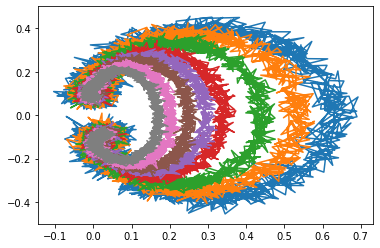

In [820]:
for cut in range(3, n):
#     popt, pcov = d.fit_abs(cut=cut, is_plot=False)
#     plt.scatter(cut, popt[-2])
    plt.plot(cd.real[cut], cd.imag[cut])
plt.show()

In [811]:
md = cd.delete_mismatch()

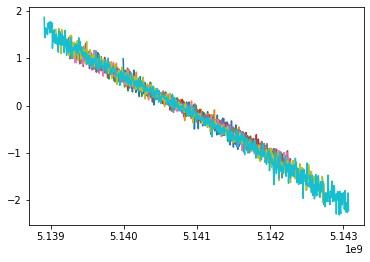

In [812]:
def linear(x, a, b): return a*x + b

P, G_2 = [], []

for cut in range(1, len(cd.power)):
    x, y = np.array(md.freq), np.array(md.arg[cut])
    ids = np.arange(*md.ig.HW_abs_ids[cut])
    popt, pcov = curve_fit(linear, x[ids], np.tan(y[ids]))
    G_2.append(-1/popt[0])
    P.append(cd.power[cut])
    plt.plot(x[ids], np.tan(y[ids]))
#     plt.plot(x[ids], linear(x[ids], *popt))
    plt.plot()
plt.show()

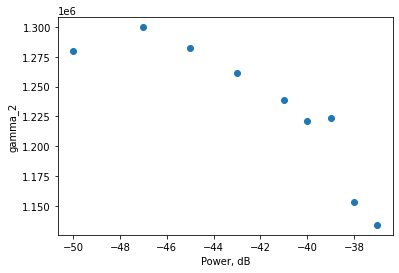

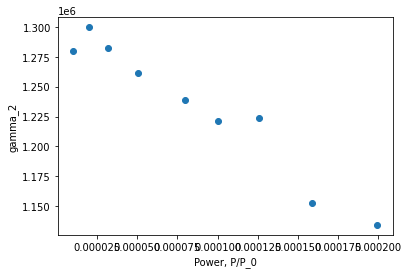

In [813]:
P, G_2 = np.array(P), np.array(G_2)
ids = range(1, len(P))

plt.scatter(P[ids], G_2[ids])
plt.xlabel('Power, dB')
plt.ylabel('gamma_2')
plt.show()

plt.scatter(10.**(0.1*P[ids]), G_2[ids])
plt.xlabel('Power, P/P_0')
plt.ylabel('gamma_2')
plt.show()

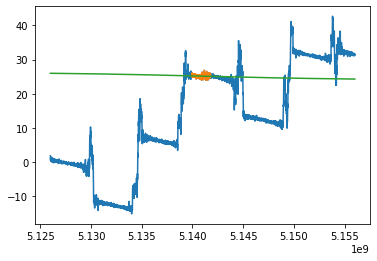

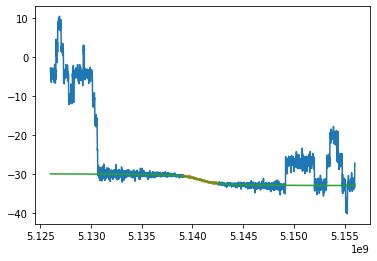

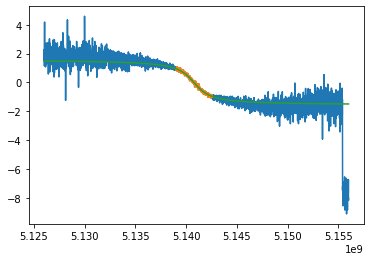

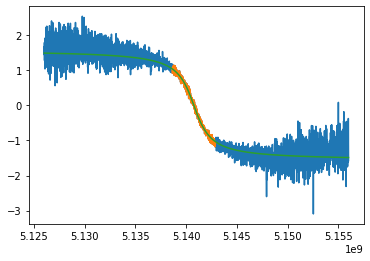

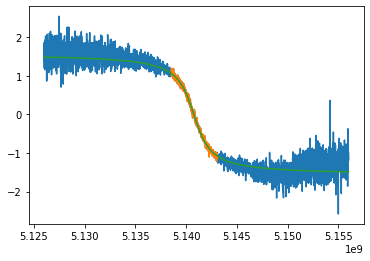

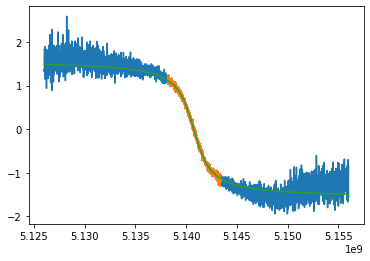

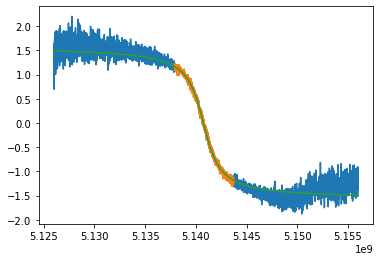

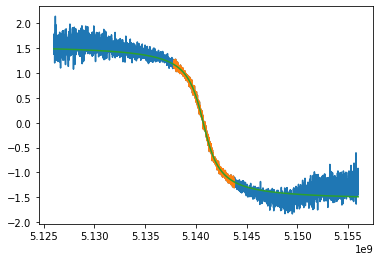

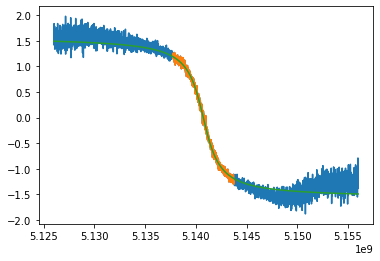

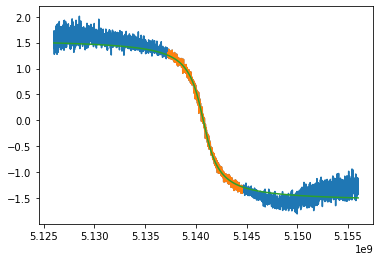

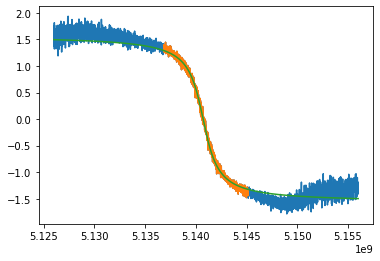

In [814]:
PHI, P, G_2 = [], [], []
for cut in range(len(md.power)):
#     try:
    popt, pcov = md.fit_canonical_arg(cut=cut, is_plot=True)
    G_2.append(popt[1])
    PHI.append(popt[0])
    P.append(cd.power[cut])
#     except: plt.show()
    plt.show()

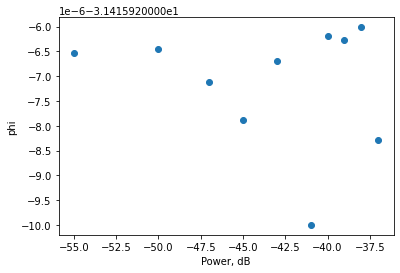

In [815]:
P, PHI = np.array(P), np.array(PHI)
ids = range(1, len(P))

plt.scatter(P[ids], np.unwrap(PHI[ids]))
plt.xlabel('Power, dB')
plt.ylabel('phi')
plt.show()

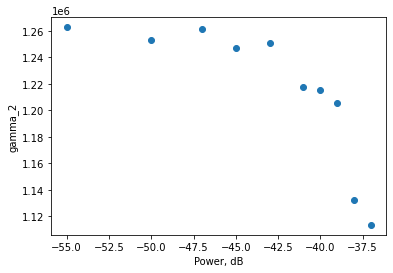

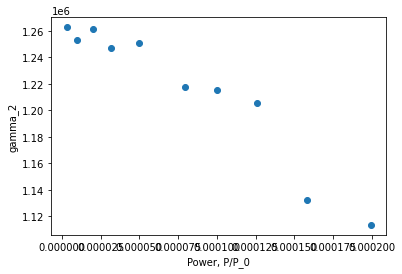

In [817]:
P, G_2 = np.array(P), np.array(G_2)
ids = range(1, len(P))

plt.scatter(P[ids], G_2[ids])
plt.xlabel('Power, dB')
plt.ylabel('gamma_2')
plt.show()

plt.scatter(10.**(0.1*P[ids]), G_2[ids])
plt.xlabel('Power, P/P_0')
plt.ylabel('gamma_2')
plt.show()

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


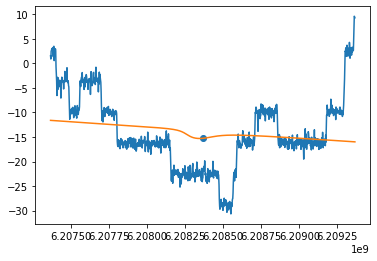

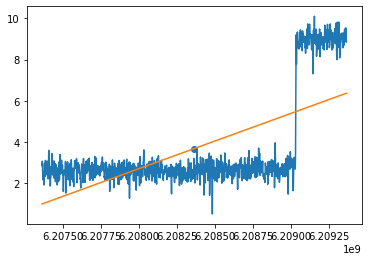

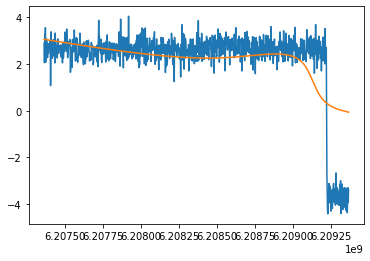

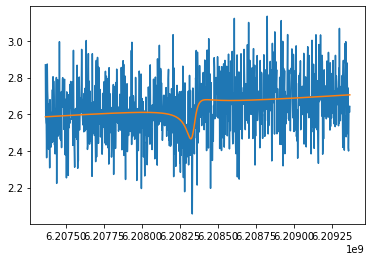

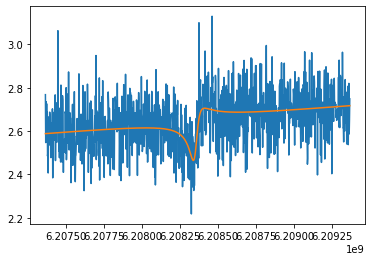

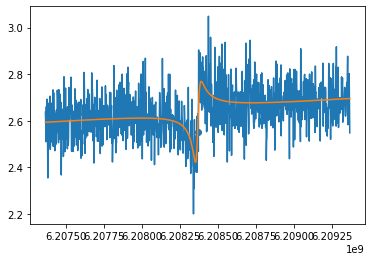

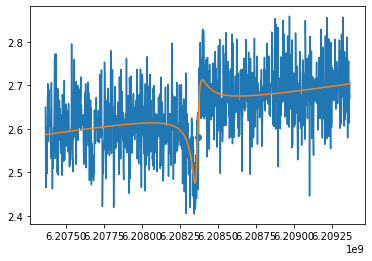

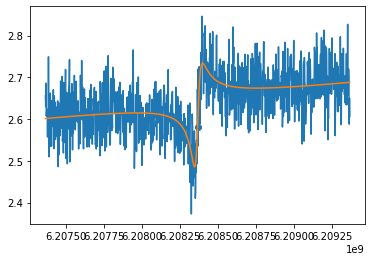

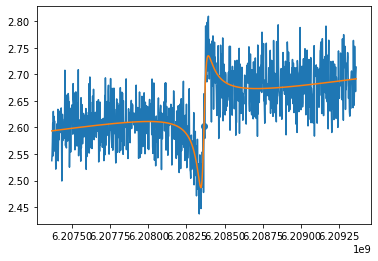

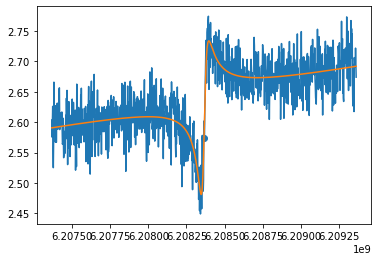

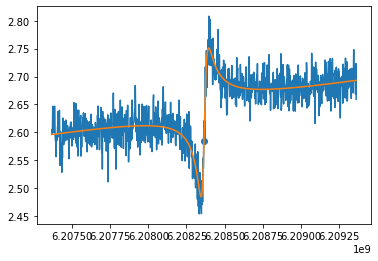

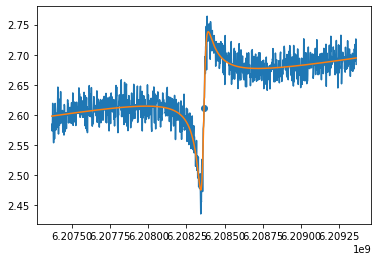

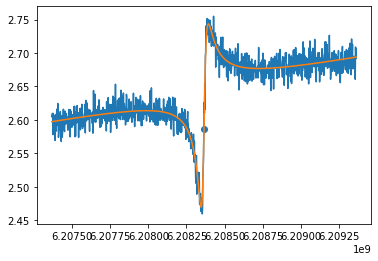

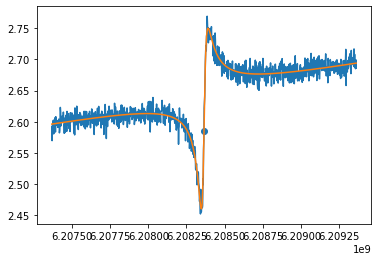

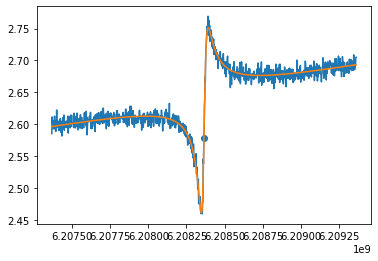

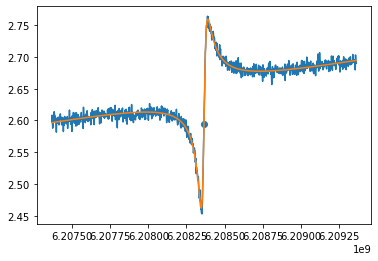

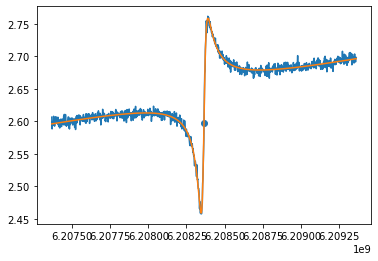

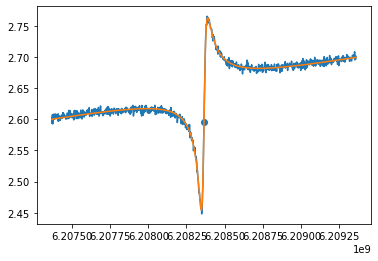

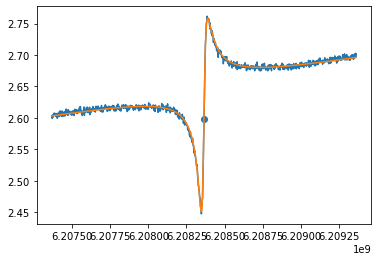

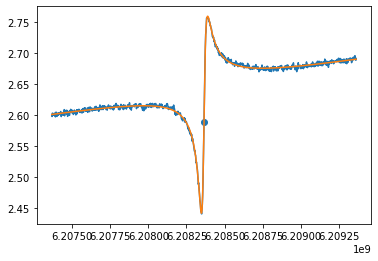

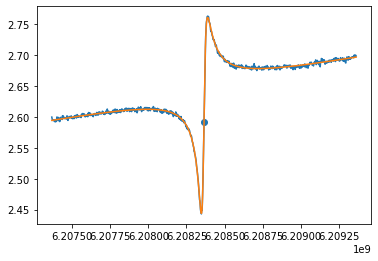

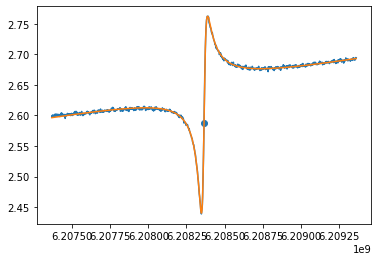

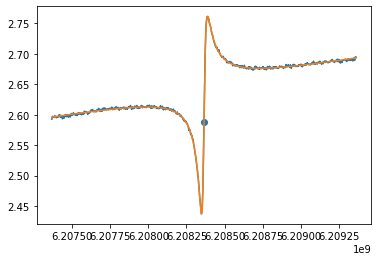

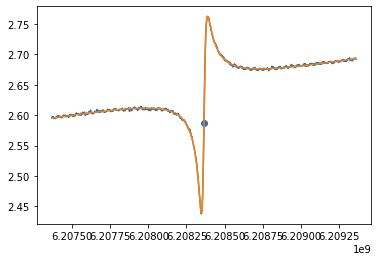

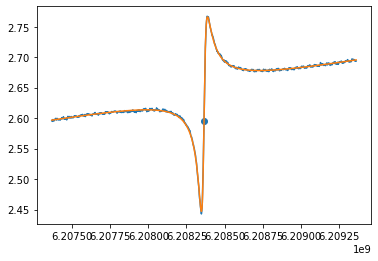

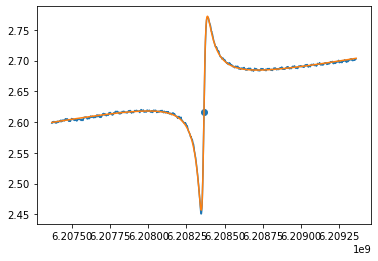

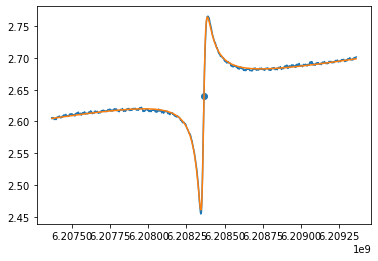

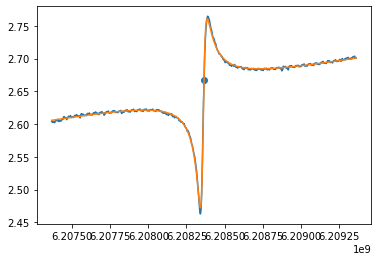

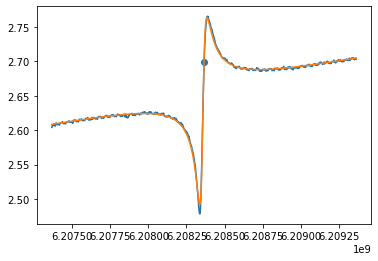

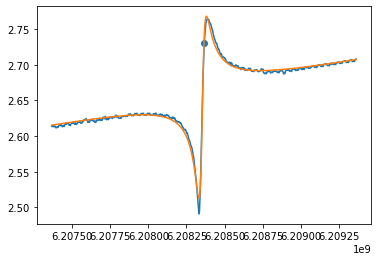

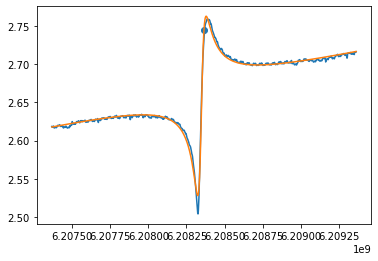

In [673]:
AA, T = [], []
for cut in range(n):
    popt, pcov = d.fit_arg(cut=cut, is_plot=True)
    AA.append(popt[-3])
    T.append(popt[-1])
    plt.show()
    
AA, T = np.array(AA), np.array(T)

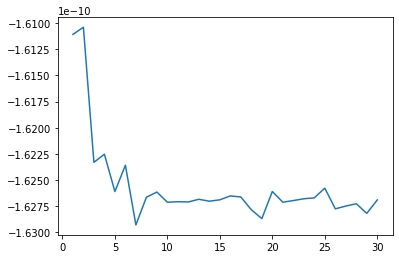

In [674]:
ids = range(1, n)
plt.plot(ids, T[ids]/AA[ids])

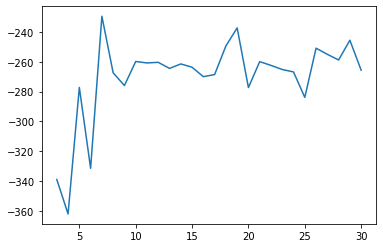

In [676]:
ids = range(3, n)
plt.plot(ids, AA[ids])

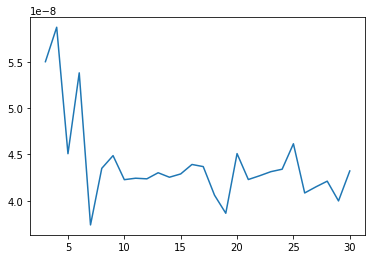

In [678]:
ids = range(3, n)
plt.plot(ids, T[ids])

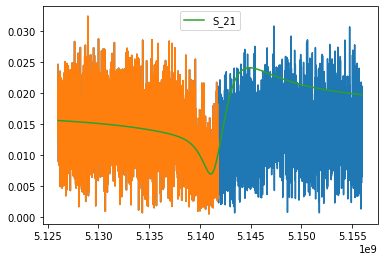

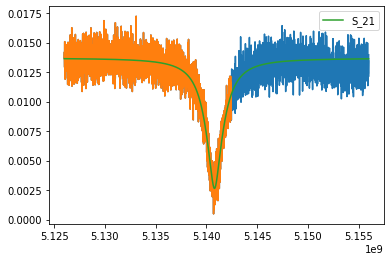

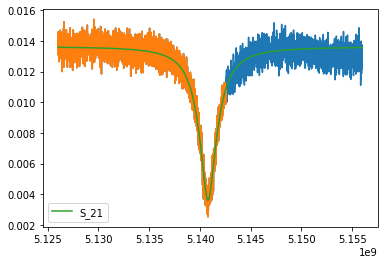

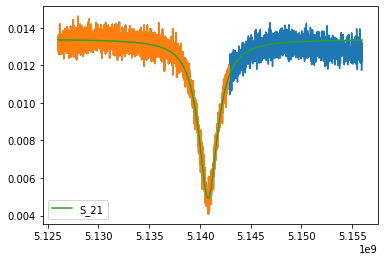

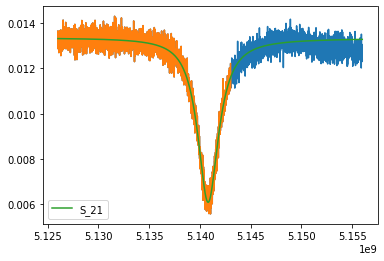

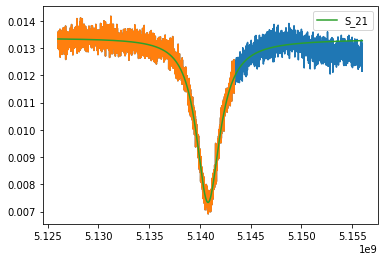

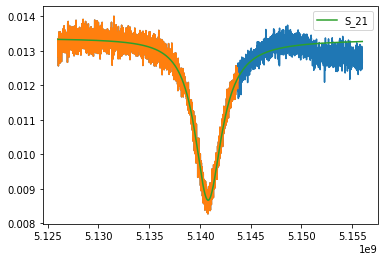

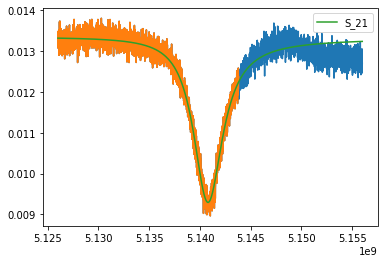

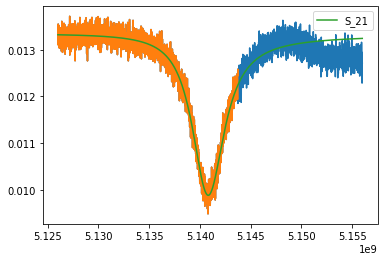

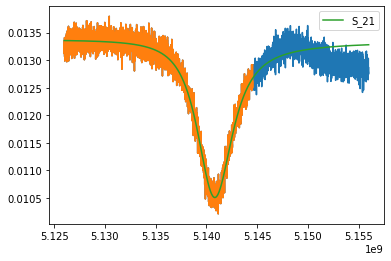

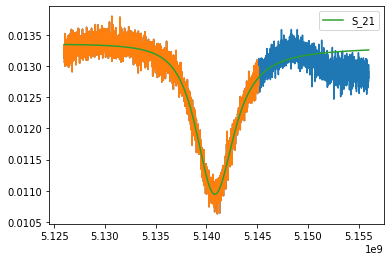

In [345]:
A, F = [], []
for cut in range(n):
    popt, pcov = d.fit_abs(cut=cut, is_plot=True)
    A.append(popt[-2])
    F.append(popt[0])
    plt.show()
    
A, F = np.array(A), np.array(F)

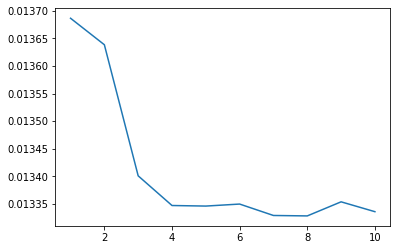

In [297]:
ids = range(1, n)
plt.plot(ids, A[ids])

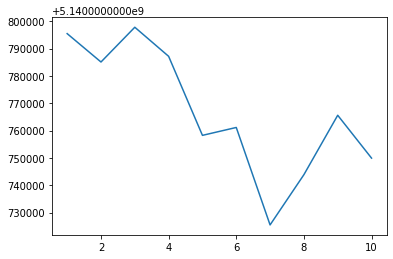

In [299]:
ids = range(1, n)
plt.plot(ids, F[ids])

In [300]:
q75 = np.percentile(A, 75)
print(q75)

0.013519755000633151


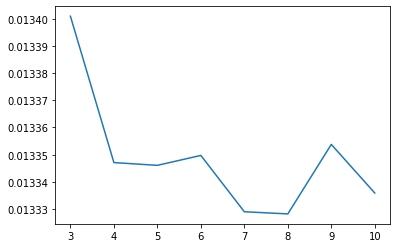

In [302]:
ids = range(3, n)
plt.plot(ids, A[A < q75])